In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, calendar
from collections import defaultdict
from sklearn import preprocessing
from sklearn import metrics
from scipy import stats
from sklearn.model_selection import train_test_split

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# neural net
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

# setup
#plotly.offline.init_notebook_mode(connected=True)
#sns.set_style(style="whitegrid")
sns.set_style('ticks')
sns.set_palette('bright')

# display charts inline
%matplotlib inline

# to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

/home/nehajain/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%%time
# load previously cleaned data from train file
train_df = pd.read_csv('data/cleaned_train.csv',index_col=0, dtype={'fullVisitorId':'str'})

/home/nehajain/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 10 s, sys: 1.47 s, total: 11.5 s
Wall time: 14.2 s


In [3]:
%%time
# load previously cleaned data from test file
test_df = pd.read_csv('data/cleaned_test.csv',index_col=0, dtype={'fullVisitorId':'str'})

CPU times: user 2.07 s, sys: 119 ms, total: 2.18 s
Wall time: 2.61 s


In [4]:
train_df.shape, test_df.shape

((1708337, 44), (401589, 40))

In [5]:
train_df = pd.concat([train_df,test_df])

In [6]:
train_df.shape

(2109926, 44)

In [135]:
train_df.to_csv('data/full_train_test.csv')

# Idea  that we are following

train1
- features: 2016/08/1 - 2017/01/15 (5.5 month) ==========visitorIds
- target: 2017/03/1 - 2017/04/30 (2 month) ==============2 month revenue for above visitorIds

train2
- features: 2017/01/15 - 2017/07/1 (5.5 month)
- target: 2017/08/15 - 2017/10/15 (2 month)

train3
- features: 2017/07/1 - 2017/12/15 (5.5 month)
- target: 2018/2/1 - 2018/4/1 (2 month)

train4
- features: 2017/12/15 - 2018/6/1 (5.5 month)
- target: 2018/7/15 - 2018/9/15 (2 month)

predict for: 2018/05/1 - 2018/10/15
<br>
submit for: 2018/12/1 - 2019/2/1


For train/test split:
1. train1-train3 for training and train4 for validation
<br>OR
2. validation set as subset of each train1-train4


In [7]:
# might not be needed if done in prev code file
# columns to drop set 2
# will give error if cols already deleted
cols_to_drop = []

# id fields serve no purpose
#cols_to_drop.append('fullVisitorId')
#cols_to_drop.append('sessionId')
cols_to_drop.append('visitId')

# date is redundant because visitStartTime includes date
#cols_to_drop.append('date')

# visitStartTime is broken into day, month etc. and exact time upto seconds doesn't make business sense
cols_to_drop.append('visitStartTime')

# continent is redundant becuase sub-continent is bit more granular but includes continent info
cols_to_drop.append('geoNetwork_continent')

# isMobile is redundant, device category already have that category
cols_to_drop.append('device_isMobile')

train_df.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2109926 entries, 0 to 401588
Data columns (total 40 columns):
channelGrouping                                 object
customDimensions_value                          object
date                                            int64
day                                             int64
device_browser                                  object
device_deviceCategory                           object
device_operatingSystem                          object
fullVisitorId                                   object
geoNetwork_city                                 object
geoNetwork_country                              object
geoNetwork_metro                                object
geoNetwork_networkDomain                        object
geoNetwork_region                               object
geoNetwork_subContinent                         object
hour                                            int64
month                                           int64
totals_bounc

# Feature generation per visitorId

## For Categorical features like geoNetwork, traffic_source etc. we can take the 3 (or 2 or 1) most frequently occurring values.
Example for a visitorId (7282998257608986241) there are these 3 top values for trafficSource_medium: 
<br>
- (none)      210
- referral    103
- organic       2

### All such categorical features (20) are following:
top2:
- channelGrouping 
- geoNetwork_city
- geoNetwork_metro
- geoNetwork_country                                                              
- geoNetwork_networkDomain                        
- geoNetwork_region                               
- geoNetwork_subContinent
- trafficSource_adContent   
- trafficSource_campaign
- trafficSource_adwordsClickInfo.slot             
- trafficSource_medium 
- trafficSource_source                            
- customDimensions_value 

<br>
top1:
<br>
- device_browser
- device_deviceCategory                           
- device_operatingSystem
- trafficSource_adwordsClickInfo.adNetworkType    
- trafficSource_adwordsClickInfo.gclId
- trafficSource_keyword   
- trafficSource_referralPath                      
   

### feature: geoNetwork_city_top1, geoNetwork_city_top2, geoNetwork_city_3

### feature: max of visitNumber

max(visitNumber)

## For boolean features can have 2 new columns for respective counts
totals_newVisits can be deleted.

Boolean columns (4) are: 
- totals_bounces
- trafficSource_adwordsClickInfo.isVideoAd
- trafficSource_isTrueDirect
- trafficSource_adwordsClickInfo.page 

### feature: bounces_0, bounces_1

respectively for counts of 0 and 1 bounces

## For numeric features like hits, pageviews etc. we can take min, max, mean, std

Such columns (5) are: 
- totals_hits 
- totals_pageviews 
- totals_sessionQualityDim              
- totals_timeOnSite
- totals_transactions

max(totals_hits),  min(totals_hits), mean(totals_hits), std(totals_hits)

## For date features we can get counts for each categoricaly level

columns (4):
- count of rows for weekday_1, weekday_1 etc.
- count of rows for month_1, month_2 etc.
- count of rows for hour_1 ...hour_24
- count of rows for day_1,...day_30

# Some NAs were not filled up earlier

In [9]:
train_df['totals_sessionQualityDim'].fillna(0,inplace=True)
train_df['totals_timeOnSite'].fillna(0,inplace=True)
train_df['totals_transactions'].fillna(0,inplace=True)
train_df['totals_transactionRevenue'].fillna(0,inplace=True)
train_df['customDimensions_value'].fillna('Unknown', inplace=True)

In [10]:
# convert categoricaly as str
cat_cols = ['fullVisitorId','geoNetwork_networkDomain','trafficSource_adwordsClickInfo.gclId',\
            'trafficSource_keyword','trafficSource_referralPath',\
            'channelGrouping','geoNetwork_city','geoNetwork_metro','geoNetwork_country',\
            'geoNetwork_region','geoNetwork_subContinent',\
            'trafficSource_adContent','trafficSource_campaign','trafficSource_adwordsClickInfo.slot',\
            'trafficSource_medium','trafficSource_source','customDimensions_value',\
            'device_browser','device_deviceCategory','device_operatingSystem',\
            'trafficSource_adwordsClickInfo.adNetworkType']

train_df[cat_cols].astype(str)

,fullVisitorId,geoNetwork_networkDomain,trafficSource_adwordsClickInfo.gclId,trafficSource_keyword,trafficSource_referralPath,channelGrouping,geoNetwork_city,geoNetwork_metro,geoNetwork_country,geoNetwork_region,geoNetwork_subContinent,trafficSource_adContent,trafficSource_campaign,trafficSource_adwordsClickInfo.slot,trafficSource_medium,trafficSource_source,customDimensions_value,device_browser,device_deviceCategory,device_operatingSystem,trafficSource_adwordsClickInfo.adNetworkType
0,3162355547410993243,(not set),Unknown,water bottle,Unknown,Organic Search,not available in demo dataset,not available in demo dataset,Germany,not available in demo dataset,Western Europe,Unknown,(not set),Unknown,organic,google,EMEA,Firefox,desktop,Windows,Unknown
1,8934116514970143966,(not set),Unknown,Unknown,/a/google.com/transportation/mtv-services/bike...,Referral,Cupertino,San Francisco-Oakland-San Jose CA,United States,California,Northern America,Unknown,(not set),Unknown,referral,sites.google.com,North America,Chrome,desktop,Chrome OS,Unknown
2,7992466427990357681,windjammercable.net,Unknown,Unknown,Unknown,Direct,not available in demo dataset,not available in demo dataset,United States,not available in demo dataset,Northern America,Unknown,(not set),Unknown,(none),(direct),North America,Chrome,mobile,Android,Unknown
3,9075655783635761930,unknown.unknown,Unknown,(not provided),Unknown,Organic Search,not available in demo dataset,not available in demo dataset,Turkey,not available in demo dataset,Western Asia,Unknown,(not set),Unknown,organic,google,EMEA,Chrome,desktop,Windows,Unknown
4,6960673291025684308,prod-infinitum.com.mx,Unknown,(not provided),Unknown,Organic Search,not available in demo dataset,not available in demo dataset,Mexico,not available in demo dataset,Central America,Unknown,(not set),Unknown,organic,google,Central America,Chrome,desktop,Windows,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401584,6701149525099562370,(not set),Unknown,(not provided),(not set),Organic Search,not available in demo dataset,not available in demo dataset,United Kingdom,not available in demo dataset,Northern Europe,(not set),(not set),Unknown,organic,google,EMEA,Chrome,mobile,Android,Unknown
401585,6154541330147351453,(not set),Unknown,(not provided),(not set),Organic Search,not available in demo dataset,not available in demo dataset,United States,not available in demo dataset,Northern America,(not set),(not set),Unknown,organic,google,North America,Chrome,desktop,Windows,Unknown
401586,6013469762773705448,(not set),Unknown,(not provided),(not set),Organic Search,not available in demo dataset,not available in demo dataset,Greece,not available in demo dataset,Southern Europe,(not set),(not set),Unknown,organic,google,Unknown,Firefox,desktop,Windows,Unknown
401587,4565378823441900999,(not set),Unknown,(not provided),(not set),Organic Search,not available in demo dataset,not available in demo dataset,United States,not available in demo dataset,Northern America,(not set),(not set),Unknown,organic,google,North America,Chrome,desktop,Chrome OS,Unknown


In [11]:
train_df.dtypes

channelGrouping               object
customDimensions_value        object
date                           int64
day                            int64
device_browser                object
                               ...  
trafficSource_referralPath    object
trafficSource_source          object
visitNumber                    int64
weekday                        int64
year                           int64
Length: 40, dtype: object

# Transform data into features

In [18]:
def generate_features_target(input_df, input_target):
    # apply all the above logic to generate new features for the 5.5 month train data and 2 month target data
    
    date_cols = ['weekday','month','hour','day']

    input_df = pd.get_dummies(input_df,columns=date_cols)
    #print("after dummies", input_df.columns)
    
    group_df = input_df.groupby('fullVisitorId')
    
    # categorical
    
    # doubtful columns...not using them for now
    doubful_cols = ['geoNetwork_networkDomain','trafficSource_adwordsClickInfo.gclId',\
            'trafficSource_keyword','trafficSource_referralPath']
    
    top2 = ['channelGrouping','geoNetwork_city','geoNetwork_metro','geoNetwork_country',\
            'geoNetwork_region','geoNetwork_subContinent',\
            'trafficSource_adContent','trafficSource_campaign','trafficSource_adwordsClickInfo.slot',\
            'trafficSource_medium','trafficSource_source','customDimensions_value']
    
    top1 = ['device_browser','device_deviceCategory','device_operatingSystem',\
            'trafficSource_adwordsClickInfo.adNetworkType']
    top = top1
    top.extend(top2)
    
    to_join = []
    for col in top:
        df = pd.DataFrame(group_df[['fullVisitorId',col]]. \
                                    apply(lambda x: stats.mode(x[col])[0][0]))
        df.columns = [col]
        to_join.append(df)
        
    final = to_join[0]   
    for i in range(1,len(to_join)):   
        final = pd.concat([final,to_join[i]],axis=1)     
    print("shape 1:", final.shape)
    
    
    
    
    # visitnumber
    max_visit_num = pd.DataFrame(group_df[['visitNumber']].max())
    max_visit_num.columns = ['max_visitNumber']    
    final = pd.concat([final,max_visit_num],axis=1)
    print("shape 2:", final.shape)
    
    
    
    
    # boolean
    bools = ['totals_bounces','trafficSource_adwordsClickInfo.isVideoAd',\
             'trafficSource_isTrueDirect','trafficSource_adwordsClickInfo.page']
    count_trues = []   
    for col in bools:
        count_trues.append(pd.DataFrame(group_df[['fullVisitorId',col]]. \
                                    sum(),columns=[col]))    
    for i in range(0,len(count_trues)):   
        final = pd.concat([final,count_trues[i]],axis=1)    
    print("shape 3:", final.shape)
    
    
    
    # numerical
    nums = ['totals_hits','totals_pageviews','totals_sessionQualityDim','totals_timeOnSite','totals_transactions']
    summary = []
    for col in nums:
        df = pd.DataFrame(group_df[[col]].min())
        df.columns = ['min_'+col]
        summary.append(df)
        
        df = pd.DataFrame(group_df[[col]].max())
        df.columns = ['max_'+col]
        summary.append(df)
        
        df = pd.DataFrame(group_df[[col]].mean())
        df.columns = ['mean_'+col]
        summary.append(df)
        
        df = pd.DataFrame(group_df[[col]].sum())
        df.columns = ['sum_'+col]
        summary.append(df)
        
        df = pd.DataFrame(group_df[[col]].apply(np.std))
        df.columns = ['std_'+col]
        summary.append(df)
        
    for i in range(0,len(summary)):   
        final = pd.concat([final,summary[i]],axis=1)    
    print("shape 4:", final.shape)
    
    
    
    # date features
    encoded_date_cols = []
    for col in input_df.columns:
        if ((col.startswith('weekday_')) | (col.startswith('hour_')) | \
            (col.startswith('day_')) | (col.startswith('month_'))):
            encoded_date_cols.append(col)
            
    print(encoded_date_cols)
    date_features = []
    for col in encoded_date_cols:       
        df = pd.DataFrame(group_df[[col]].sum())
        df.columns = [col]
        date_features.append(df)
        
    for i in range(0,len(date_features)):   
        final = pd.concat([final,date_features[i]],axis=1)    
    print("shape 5:", final.shape)    
    #print("final columns: ", final.columns)
    
    
    
    
    # get dummies for final categorical features
    final = pd.get_dummies(final,columns=top)
    print("shape 6:", final.shape)   
    
    
    # target
    if(input_target.shape[0] != 0):
        y = pd.DataFrame(input_target.groupby('fullVisitorId')['totals_transactionRevenue'].sum())
        y.columns = ['target']

        train_data = pd.merge(final, y, how='left', left_index=True, right_index=True)
        train_data['target'].fillna(0,inplace=True)
        print("shape of train data:", train_data.shape)        
        return train_data
    else:
        return final

In [44]:
# target
def get_target(final, input_target):
    if(input_target.shape[0] != 0):
        y = pd.DataFrame(input_target.groupby('fullVisitorId')['totals_transactionRevenue'].sum())
        y.columns = ['target']

        train_data = pd.merge(final, y, how='left', left_index=True, right_index=True)
        train_data['target'].fillna(0,inplace=True)
        print("shape of train data:", train_data.shape)        
        return train_data
    else:
        return final

In [19]:
# 2016/08/1 - 2017/01/15 
#set_1_feats = train_df[(train_df.date>=20160801) & (train_df.date<20170115)]
set_1_feats = train_df[(train_df.date>=20170101) & (train_df.date<20170115)]
print(set_1_feats.shape)

# 2017/03/1 - 2017/04/30
set_1_target = train_df[(train_df.date>=20170301) & (train_df.date<=20170430)][['fullVisitorId','totals_transactionRevenue']]
print(set_1_target.shape)

# big call
train_set_1 = generate_features_target(set_1_feats,set_1_target)

(27889, 40)
(137057, 2)


/home/nehajain/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


shape 1: (23404, 16)
shape 2: (23404, 17)
shape 3: (23404, 21)
shape 4: (23404, 46)
['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15']
shape 5: (23404, 93)
shape 6: (23404, 668)
shape of train data: (23404, 669)


In [23]:
train_set_1.shape

(23404, 669)

In [24]:
# delete columns that are not in predicting features
del_cols = list(set(train_set_1) - set(X_predict.columns))
print(len(del_cols))
train_set_1.drop(del_cols,axis=1,inplace=True)

47


In [46]:
# temporary
train_set_1 = get_target(train_set_1,set_1_target)

shape of train data: (23404, 623)


In [25]:
train_set_1.shape

(23404, 622)

In [26]:
# 2016/08/1 - 2017/01/15 
#set_1_feats = train_df[(train_df.date>=20160801) & (train_df.date<20170115)]
set_2_feats = train_df[(train_df.date>=20170115) & (train_df.date<20170701)]
print(set_2_feats.shape)

# 2017/03/1 - 2017/04/30
set_2_target = train_df[(train_df.date>=20170815) & (train_df.date<=20171015)][['fullVisitorId','totals_transactionRevenue']]
print(set_2_target.shape)

# big call
train_set_2 = generate_features_target(set_2_feats,set_2_target)

(365003, 40)
(187455, 2)


/home/nehajain/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


shape 1: (286797, 16)
shape 2: (286797, 17)
shape 3: (286797, 21)
shape 4: (286797, 46)
['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31']
shape 5: (286797, 115)
shape 6: (286797, 1369)
shape of train data: (286797, 1370)


In [27]:
# delete columns that are not in predicting features
del_cols = list(set(train_set_2) - set(X_predict.columns))
print(len(del_cols))
train_set_2.drop(del_cols,axis=1,inplace=True)

379


In [47]:
# temporary
train_set_2 = get_target(train_set_2,set_2_target)

shape of train data: (286797, 992)


In [48]:
train_set_2.shape

(286797, 992)

In [29]:
# 2016/08/1 - 2017/01/15 
#set_1_feats = train_df[(train_df.date>=20160801) & (train_df.date<20170115)]
set_3_feats = train_df[(train_df.date>=20170701) & (train_df.date<20171215)]
print(set_3_feats.shape)

# 2017/03/1 - 2017/04/30
set_3_target = train_df[(train_df.date>=20180201) & (train_df.date<=20180401)][['fullVisitorId','totals_transactionRevenue']]
print(set_3_target.shape)

# big call
train_set_3 = generate_features_target(set_3_feats,set_3_target)

(493216, 40)
(179161, 2)


/home/nehajain/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


shape 1: (382460, 16)
shape 2: (382460, 17)
shape 3: (382460, 21)
shape 4: (382460, 46)
['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31']
shape 5: (382460, 114)
shape 6: (382460, 1688)
shape of train data: (382460, 1689)


In [30]:
# delete columns that are not in predicting features
del_cols = list(set(train_set_3) - set(X_predict.columns))
print(len(del_cols))
train_set_3.drop(del_cols,axis=1,inplace=True)

563


In [49]:
# temporary
train_set_3 = get_target(train_set_3,set_3_target)

shape of train data: (382460, 1127)


In [50]:
train_set_3.shape

(382460, 1127)

In [110]:
# set_1_target.to_csv('data/set_1_target.csv')
# set_2_target.to_csv('data/set_2_target.csv')
# set_3_target.to_csv('data/set_3_target.csv')
# set_4_target.to_csv('data/set_4_target.csv')

In [32]:
%%time
# 2016/08/1 - 2017/01/15 
#set_1_feats = train_df[(train_df.date>=20160801) & (train_df.date<20170115)]
set_4_feats = train_df[(train_df.date>=20171215) & (train_df.date<20180601)]
print(set_4_feats.shape)

# 2017/03/1 - 2017/04/30
set_4_target = train_df[(train_df.date>=20180715) & (train_df.date<=20180915)][['fullVisitorId','totals_transactionRevenue']]
print(set_4_target.shape)

# big call
train_set_4 = generate_features_target(set_4_feats,set_4_target)

(472549, 40)
(139276, 2)


/home/nehajain/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


shape 1: (367164, 16)
shape 2: (367164, 17)
shape 3: (367164, 21)
shape 4: (367164, 46)
['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31']
shape 5: (367164, 115)
shape 6: (367164, 1651)
shape of train data: (367164, 1652)
CPU times: user 14min 47s, sys: 26 s, total: 15min 13s
Wall time: 14min 50s


In [33]:
# delete columns that are not in predicting features
del_cols = list(set(train_set_4) - set(X_predict.columns))
print(len(del_cols))
train_set_4.drop(del_cols,axis=1,inplace=True)

466


In [51]:
# temporary
train_set_4 = get_target(train_set_4,set_4_target)

shape of train data: (367164, 1187)


In [52]:
train_set_4.shape

(367164, 1187)

In [74]:
#train_set_4[0:2]

,max_visitNumber,totals_bounces,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.page,min_totals_hits,max_totals_hits,mean_totals_hits,sum_totals_hits,std_totals_hits,min_totals_pageviews,max_totals_pageviews,mean_totals_pageviews,sum_totals_pageviews,std_totals_pageviews,min_totals_sessionQualityDim,max_totals_sessionQualityDim,mean_totals_sessionQualityDim,sum_totals_sessionQualityDim,std_totals_sessionQualityDim,min_totals_timeOnSite,max_totals_timeOnSite,mean_totals_timeOnSite,sum_totals_timeOnSite,std_totals_timeOnSite,min_totals_transactions,max_totals_transactions,mean_totals_transactions,sum_totals_transactions,std_totals_transactions,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_5,month_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,device_browser_+Simple Browser,device_browser_;__CT_JOB_ID__:58e83b88-5694-4771-be2d-27cc97b0ca1f;,device_browser_Amazon Silk,device_browser_Android Browser,device_browser_Android Webview,device_browser_BlackBerry,device_browser_Chrome,device_browser_Coc Coc,device_browser_Edge,device_browser_Firefox,device_browser_GameSessions CEF,device_browser_GemiusSDK,device_browser_HubSpot inbound link reporting check,device_browser_Internet Explorer,device_browser_Iron,device_browser_MRCHROME,device_browser_Maxthon,device_browser_Mozilla,device_browser_Mozilla Compatible Agent,device_browser_Netscape,device_browser_Nintendo Browser,device_browser_Nokia Browser,device_browser_NokiaC7-00,device_browser_Opera,device_browser_Opera Mini,device_browser_Playstation Vita Browser,device_browser_Puffin,device_browser_Quora 2.6.26 rv:1470.0 env:prod wv:66.0.3359.158,device_browser_Safari,device_browser_Safari (in-app),device_browser_Samsung Internet,device_browser_SeaMonkey,device_browser_UC Browser,device_browser_YaBrowser,device_browser_i-mobile i-STYLE 8.5,device_browser_osee2unifiedRelease,device_deviceCategory_desktop,device_deviceCategory_mobile,device_deviceCategory_tablet,device_operatingSystem_(not set),device_operatingSystem_Android,device_operatingSystem_BlackBerry,device_operatingSystem_Chrome OS,device_operatingSystem_Firefox OS,device_operatingSystem_FreeBSD,device_operatingSystem_Linux,device_operatingSystem_Macintosh,device_operatingSystem_Nintendo WiiU,device_operatingSystem_Nokia,device_operatingSystem_OS/2,device_operatingSystem_Playstation Vita,device_operatingSystem_Samsung,device_operatingSystem_Solaris,device_operatingSystem_SunOS,device_operatingSystem_SymbianOS,device_operatingSystem_Tizen,device_operatingSystem_Windows,device_operatingSystem_Windows Phone,device_operatingSystem_Xbox,device_operatingSystem_iOS,trafficSource_adwordsClickInfo.adNetworkType_Content,trafficSource_adwordsClickInfo.adNetworkType_Google Search,trafficSource_adwordsClickInfo.adNetworkType_Unknown,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,geoNetwork_city_(not set),geoNetwork_city_Aberdeen,geoNetwork_city_Adachi,geoNetwork_city_Adelaide,geoNetwork_city_Agra,geoNetwork_city_Ahmedabad,geoNetwork_city_Akron,geoNetwork_city_Alicante,geoNetwork_city_Amberg,geoNetwork_city_Amersfoort,geoNetwork_city_Amsterdam,geoNetwork_city_Ankara,geoNetwork_city_Ann Arbor,geoNetwork_city_Antwerp,geoNetwork_city_Arlington,geoNetwork_city_Ashburn,geoNetwork_city_Athens,geoNetwork_city_Atlanta,geoNetwork_city_Auckland,geoNetwork_city_Austin,geoNetwork_city_Aveiro,geoNetwork_city_Bandung,geoNetwork_city_Bangkok,geoNetwork_city_Barcelona,geoNetwork_city_Barrie,

In [79]:
#train_all['trafficSource_isTrueDirect'][692660:692664]

692660    0
692661    0
692662    3
692663    0
Name: trafficSource_isTrueDirect, dtype: int64

In [14]:
# temporary load from saved files
# train_set_1 = pd.read_csv('data/set_1_target.csv',index_col=0)
# train_set_2 = pd.read_csv('data/set_2_target.csv',index_col=0)
# train_set_3 = pd.read_csv('data/set_3_target.csv',index_col=0)
# train_set_4 = pd.read_csv('data/set_4_target.csv',index_col=0)

In [53]:
# it will have nulls
train_all = pd.concat([train_set_1, train_set_2, train_set_3, train_set_4], axis=0, ignore_index=True)
train_all.shape

(1059825, 1273)

In [54]:
train_all.memory_usage().sum()

6453274505

In [37]:
print(list(train_all.columns))

['channelGrouping_(Other)', 'channelGrouping_Affiliates', 'channelGrouping_Direct', 'channelGrouping_Display', 'channelGrouping_Organic Search', 'channelGrouping_Paid Search', 'channelGrouping_Referral', 'channelGrouping_Social', 'customDimensions_value_APAC', 'customDimensions_value_Central America', 'customDimensions_value_EMEA', 'customDimensions_value_North America', 'customDimensions_value_South America', 'customDimensions_value_Unknown', 'day_1', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_3', 'day_30', 'day_31', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'device_browser_+Simple Browser', 'device_browser_;__CT_JOB_ID__:58e83b88-5694-4771-be2d-27cc97b0ca1f;', 'device_browser_Amazon Silk', 'device_browser_Android Browser', 'device_browser_Android Webview', 'device_browser_BlackBerry', 'device_browser_Chr

In [136]:
# delete files in memory to save space
# test_df = None
# temp = None
# test_df = None
# train_df = None


In [148]:
train_all.memory_usage()

Index                              80
channelGrouping_(Other)       8478600
channelGrouping_Affiliates    1059825
channelGrouping_Direct        1059825
channelGrouping_Display       1059825
                               ...   
weekday_2                     1059825
weekday_3                     1059825
weekday_4                     1059825
weekday_5                     1059825
weekday_6                     1059825
Length: 2311, dtype: int64

In [55]:
# remove nulls
for col in range(0,len(train_all.columns)):
    #print(col)
    train_all.iloc[:,col].fillna(0,inplace=True)

In [56]:
train_all.head()

,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,customDimensions_value_APAC,customDimensions_value_Central America,customDimensions_value_EMEA,customDimensions_value_North America,customDimensions_value_South America,customDimensions_value_Unknown,day_1,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_2,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,device_browser_+Simple Browser,device_browser_;__CT_JOB_ID__:58e83b88-5694-4771-be2d-27cc97b0ca1f;,device_browser_Amazon Silk,device_browser_Android Browser,device_browser_Android Webview,device_browser_BlackBerry,device_browser_Chrome,device_browser_Coc Coc,device_browser_Edge,device_browser_Firefox,device_browser_GameSessions CEF,device_browser_GemiusSDK,device_browser_HubSpot inbound link reporting check,device_browser_Internet Explorer,device_browser_Iron,device_browser_MRCHROME,device_browser_Maxthon,device_browser_Mozilla,device_browser_Mozilla Compatible Agent,device_browser_Netscape,device_browser_Nintendo Browser,device_browser_Nokia Browser,device_browser_NokiaC7-00,device_browser_Opera,device_browser_Opera Mini,device_browser_Playstation Vita Browser,device_browser_Puffin,device_browser_Quora 2.6.26 rv:1470.0 env:prod wv:66.0.3359.158,device_browser_Safari,device_browser_Safari (in-app),device_browser_Samsung Internet,device_browser_SeaMonkey,device_browser_UC Browser,device_browser_YaBrowser,device_browser_i-mobile i-STYLE 8.5,device_browser_osee2unifiedRelease,device_deviceCategory_desktop,device_deviceCategory_mobile,device_deviceCategory_tablet,device_operatingSystem_(not set),device_operatingSystem_Android,device_operatingSystem_BlackBerry,device_operatingSystem_Chrome OS,device_operatingSystem_Firefox OS,device_operatingSystem_FreeBSD,device_operatingSystem_Linux,device_operatingSystem_Macintosh,device_operatingSystem_Nintendo WiiU,device_operatingSystem_Nokia,device_operatingSystem_OS/2,device_operatingSystem_Playstation Vita,device_operatingSystem_Samsung,device_operatingSystem_Solaris,device_operatingSystem_SunOS,device_operatingSystem_SymbianOS,device_operatingSystem_Tizen,device_operatingSystem_Windows,device_operatingSystem_Windows Phone,device_operatingSystem_Xbox,device_operatingSystem_iOS,geoNetwork_city_(not set),geoNetwork_city_Aalborg,geoNetwork_city_Aberdeen,geoNetwork_city_Adachi,geoNetwork_city_Addis Ababa,geoNetwork_city_Adelaide,geoNetwork_city_Agra,geoNetwork_city_Ahmedabad,geoNetwork_city_Akron,geoNetwork_city_Alicante,geoNetwork_city_Amberg,geoNetwork_city_Amersfoort,geoNetwork_city_Amsterdam,geoNetwork_city_Ankara,geoNetwork_city_Ann Arbor,geoNetwork_city_Antwerp,geoNetwork_city_Arequipa,geoNetwork_city_Arlington,geoNetwork_city_Ashburn,geoNetwork_city_Athens,geoNetwork_city_Atlanta,geoNetwork_city_Auckland,geoNetwork_city_Austin,geoNetwork_city_Aveiro,geoNetwork_city_Bandung,geoNetwork_city_Bangkok,geoNetwork_city_Barcelona,geoNetwork_city_Barranquilla,geoNetwork_city_Barrie,geoNetwork_city_Beijing,geoNetwork_city_Belfast,geoNetwork_city_Belgrade,geoNetwork_city_Bellevue,geoNetwork_city_Bellingham,geoNetwork_city_Belo Horizonte,geoNetwork_city_Bengaluru,geoNetwork_city_Benton Harbor,geoNetwork_city_Berkeley,geoNetwork_city_Berlin,geoNetwork_city_Bhopal,geoNetwork_city_Bhubaneswar,geoNetwork_city_Birmingham,geoNetwork_city_Boca Raton,geoNetwork_city_Bogota,geoNetwork_city_Boston,geoNetwork_city_Boucherville,geoNetwork_city_Boulder,geoNetwork_city_Brasilia,geoNetwork_city_Bratislava,geoNetwork_city_Breda,geoNetwork_city_Brighton,geoNetwork_city_Brisbane,geoNetwork_city_Brno,geoNetwork_city_Brussels,geoNetwork_city_Bucharest,geoNetwork_city_Budapest,geoNetwork_city_Buenos Aires,geoNetwork_city_Burnaby,geoNetwork_city_Cairo,geoNetwork_city_Calgary,geoNetwork_city_Cali,geoNetwork_city_Cambri

In [57]:
train_all['target']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1059820    0.0
1059821    0.0
1059822    0.0
1059823    0.0
1059824    0.0
Name: target, Length: 1059825, dtype: float64

In [58]:
# get train test based on time split
def get_train_test(df):
    X = df.drop(['target'],axis=1)
    y = df['target']
    y = np.log1p(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test    

In [59]:
#X_train_1, X_test_1, y_train_1, y_test_1 = get_train_test(train_set_1) 
# temp = train_all.iloc[100,:]
# print(temp.shape)
X_train_1, X_test_1, y_train_1, y_test_1 = get_train_test(train_all[-150000:])

In [60]:
X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape

((120000, 1272), (30000, 1272), (120000,), (30000,))

In [61]:
# custom function to run light gbm model
# might try with a different validation set, not doing because we have extra test set file for submission
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
#         "num_leaves" : 30,
#         "min_child_samples" : 100,
#         "learning_rate" : 0.1,
#         "bagging_fraction" : 0.7,
#         "feature_fraction" : 0.5,
#         "bagging_frequency" : 5,
#         "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y

# Train the model

In [62]:
# Training the model #
lgb_model, pred_val_lgb = run_lgb(X_train_1, y_train_1, X_test_1, y_test_1)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.234848
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.229945


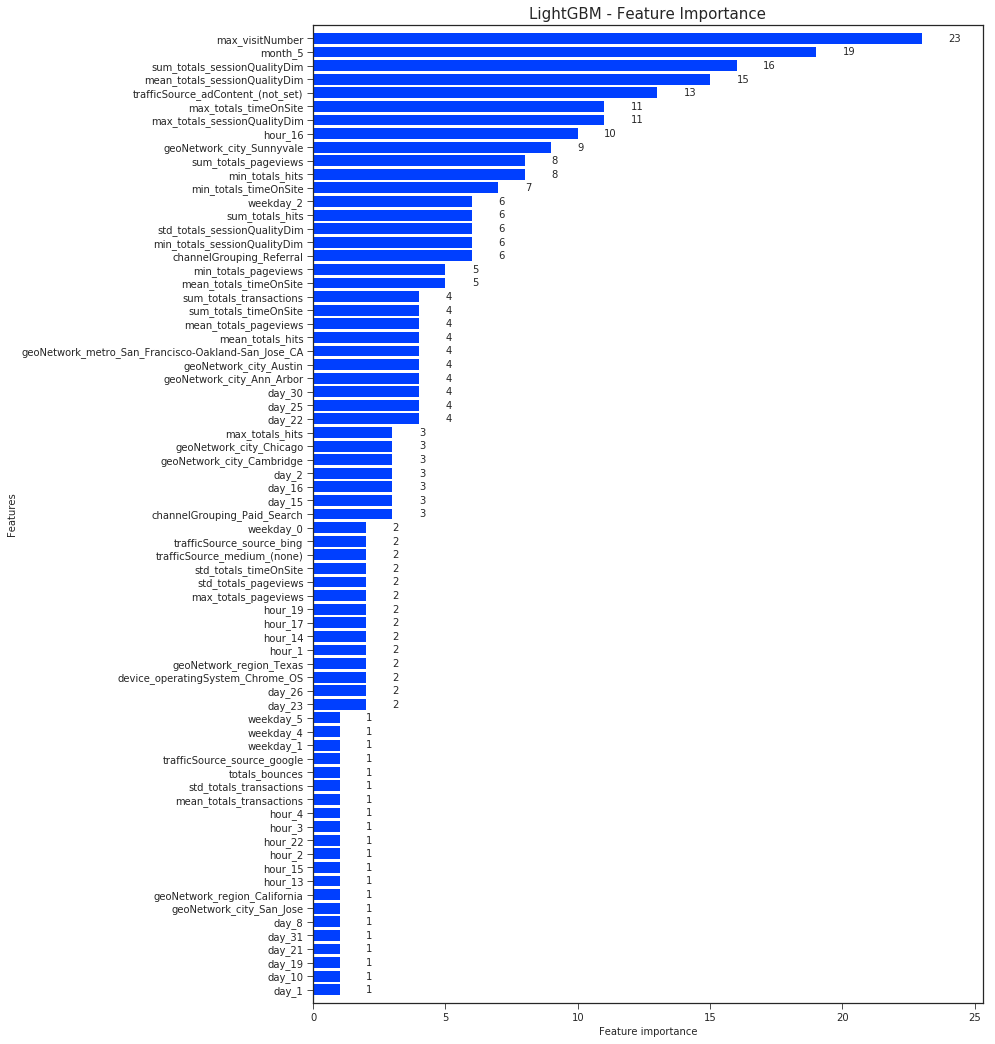

In [63]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

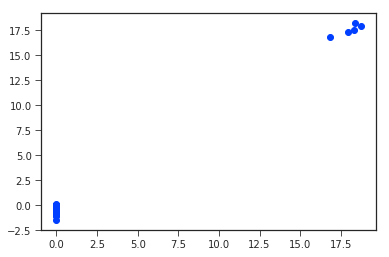

In [64]:
plt.scatter(x=y_test_1, y=(y_test_1-pred_val_lgb))


# Final predictions

In [13]:
%%time
# 2016/08/1 - 2017/01/15 
#set_1_feats = train_df[(train_df.date>=20160801) & (train_df.date<20170115)]
pred_feats = train_df[(train_df.date>=20180501) & (train_df.date<20181015)]
print(pred_feats.shape)

# 2017/03/1 - 2017/04/30
# set_4_target = train_df[(train_df.date>=20180715) & (train_df.date<=20180915)][['fullVisitorId','totals_transactionRevenue']]
# print(set_4_target.shape)

# big call
X_predict = generate_features_target(pred_feats, pd.DataFrame())

(398742, 40)


/home/nehajain/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


shape 1: (294530, 16)
shape 2: (294530, 17)
shape 3: (294530, 21)
shape 4: (294530, 46)
['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31']
shape 5: (294530, 114)
shape 6: (294530, 1527)
CPU times: user 11min 27s, sys: 20.1 s, total: 11min 47s
Wall time: 11min 30s


In [ ]:
#X_predict.to_csv('data/X_predict.csv')

In [66]:
y_predict = lgb_model.predict(X_predict)

In [67]:
y_predict

array([0.00244204, 0.00330408, 0.00330408, ..., 0.00330408, 0.00244204,
       0.00244204])

In [82]:
visitorIds = list(train_set_1.index.values)

In [83]:
visitorIds.extend(list(train_set_2.index.values))
visitorIds.extend(list(train_set_3.index.values))
visitorIds.extend(list(train_set_4.index.values))

In [84]:
visitorIds

['0000613897283848534',
 '0000641787877778885',
 '0001277385672710758',
 '0001858327036304483',
 '0002113059720701099',
 '0003297619580760716',
 '0003961110741104601',
 '0004204957972065597',
 '0004359630748414109',
 '0005045990529285434',
 '0005113509587349615',
 '0005224157940049074',
 '0006167988871087633',
 '0006506653828422071',
 '0006825549445979163',
 '000710448170978711',
 '0007378361736355616',
 '0008712721509172492',
 '0009038723733767042',
 '0009101120723375357',
 '000923747808925443',
 '0009698866295854774',
 '0009734103988256050',
 '0010168878280038048',
 '0010394362989787191',
 '0011148821686448845',
 '0011296111936649223',
 '0011640236432172878',
 '0012534973125429259',
 '001324382917654255',
 '0013305062664613882',
 '0013793724006883191',
 '0014884852016449602',
 '0014997413479849928',
 '0015380664562516520',
 '001596036581292713',
 '0016316356325418630',
 '0016883628233932470',
 '0016959150196306940',
 '0017209370805326703',
 '0018431897310656180',
 '001857471325201513

In [91]:
X_predict.index

Index(['0000018966949534117', '0000039738481224681', '0000073585230191399',
       '0000087588448856385', '0000149787903119437', '0000196310838896290',
       '00001995526696366', '0000255704530917106', '0000268499301061358',
       '0000276747989270229',
       ...
       '9999719906093788809', '999978076626266690', '9999789650718817732',
       '9999801750392194671', '9999811691734361404', '9999862054614696520',
       '9999898168621645223', '999990167740728398', '9999915620249883537',
       '9999947552481876143'],
      dtype='object', name='fullVisitorId', length=294530)

In [101]:
submission = pd.DataFrame(X_predict.index.values,columns=['fullVisitorId'])

In [102]:
submission.shape, y_predict.shape

((294530, 1), (294530,))

In [103]:
submission['PredictedLogRevenue'] = y_predict

In [104]:
submission

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.002442
1,0000039738481224681,0.003304
2,0000073585230191399,0.003304
3,0000087588448856385,0.003304
4,0000149787903119437,0.003304
...,...,...
294525,9999862054614696520,0.002442
294526,9999898168621645223,0.002442
294527,999990167740728398,0.003304
294528,9999915620249883537,0.002442


In [105]:
submission.to_csv('data/submission_nov30.csv',index=False)